In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

import sys
helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib

cmap = plt.get_cmap('viridis')
plt.rcParams['figure.dpi'] = 150

In [1]:
# parameters
params = np.array(['P0', 'Tint', 'CplusO', 'CtoO'])

P0s = np.array([1e6, 1e7, 1e8]) # surface pressure in dyn/cm^2
Tints = np.array([50, 75, 100, 125, 150, 200, 250])#, 300, 350]) # internal temperature in K

CplusOs = np.array([1e-3, 3.16e-3, 1e-2, 3.16e-2, 1e-1])
CtoOs = np.array([0.1, 0.59, 1.0])

folder = '../output/EqCond+Remove/'

NameError: name 'np' is not defined

In [2]:
def format_e_nums(num):
    num = f'{num:.2e}'.replace('0', '').replace('.e', 'e').replace('+', '')
    if num[-1] == 'e':
        num = num + '0'
    return num

def format_CtoO_float(f):
    if f == int(f):  # Check if it's a whole number
        return f"{f:.1f}"  # Format as integer if whole
    else:
        return f"{f:.10g}" # Use g format with sufficient precision.

def built_name(loop_over, P0, Tint, CplusO, CtoO, i_param=None, noCond=False, planet='Earth'):
    if noCond:
        noCond = '_NoCond'
    else:
        noCond = ''

    if i_param == 0 or (i_param == None and loop_over in P0s):
        return f'{planet}_P0={format_e_nums(loop_over)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 1 or (i_param == None and loop_over in Tints):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={loop_over}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 2 or (i_param == None and loop_over in CplusOs):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(loop_over)}_CtoO={format_CtoO_float(CtoO)}'
    elif i_param == 3 or (i_param == None and loop_over in CtoOs):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(loop_over)}'
    else:
        raise ValueError('Invalid loop_over value')

def extract_data(loop_overs, i_P0=0, i_Tint=0, i_CplusO=0, i_CtoO=0, noCond=False, planet='Earth'):
        
    data_dict = {
        "inds": [],
        "PTs": [],
        "nHtots": [],
        "data": [],
        "atoms": [],
        "mols": [],
        "supersats": [],
        "dusts": [],
        "mus": [],
        "convergence": [],
        "n_iter": [],
        "ntots": [],
        "eps_atoms": [],
        "dust_to_gas": [],
        "dust_vol": []
    }

    for i, loop_over in enumerate(loop_overs):
        name = built_name(loop_over, P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO], noCond=noCond, planet=planet)
        #print(name)

        path = folder + name + "/Static_Conc_{var}.dat"
        conv = True
        j = 0

        while True:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                try:
                    d = np.loadtxt(path.format(var=j), skiprows=3)
                    convergence_conditions = d[-1,2] != 1e-1
                    convergence_conditions = convergence_conditions and not np.all(d[:,0] == 1.001)
                    if convergence_conditions: # if pressure is not 0.1 dyn/cm^2 (=1e-7 bar), then the simulation did not converge
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                        j -= 1
                        break
                    j += 1
                except (FileNotFoundError, UserWarning) as warn:
                    if warn.__class__ == UserWarning:
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                    j -= 1
                    break

        if i == 0:
            dimension = np.genfromtxt(path.format(var=0), dtype=int,  max_rows=1, skip_header=1)
            global n_elem, n_mol, n_dust, n_layers
            n_elem = dimension[0]
            n_mol = dimension[1]
            n_dust = dimension[2]
            n_layers = dimension[3]

            header = np.loadtxt(path.format(var=j), skiprows=2, max_rows=1, dtype=str)
            global atom_names, mol_names, dust_names
            atom_names = header[3:4+n_elem]
            mol_names = header[4+n_elem:4+n_elem+n_mol]
            dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
            dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)
        
        if j == -1:
            d = np.zeros_like(d)
            d[:,:] = np.nan

            mu = np.zeros_like(mu)
            mu[:] = np.nan

            j = np.nan
        else:
            d = np.loadtxt(path.format(var=j), skiprows=3)
            data_dict["data"].append(d)

            try:
                mu = path[:-21] + f'vertical_mix_{j}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
            except FileNotFoundError:
                print('WARNING: ' + path[:-21] + f'vertical_mix_{j}.dat' + ' not found')
                mu = path[:-21] + f'vertical_mix_{j-1}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
                conv = False

        data_dict["PTs"].append(np.array([d[:, 2] * 1e-6, d[:, 0]]).T)  # convert pressure from dyn/cm^2 to bar
        data_dict["nHtots"].append(d[:, 1])
        data_dict["atoms"].append(d[:, 3:4+n_elem])
        data_dict["mols"].append(d[:, 4+n_elem:4+n_elem+n_mol])
        data_dict["supersats"].append(d[:, 4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
        data_dict["dusts"].append(d[:, 4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])
        data_dict["eps_atoms"].append(d[:, 4+n_elem+n_mol+2*n_dust:4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_to_gas"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_vol"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem+1])
        data_dict["inds"].append(i)
        data_dict["mus"].append(mu)

        data_dict["convergence"].append(conv)
        data_dict["n_iter"].append(j)
    
    if not data_dict["inds"]:
        data_dict["inds"] = np.empty((1))
        data_dict["PTs"] = np.empty((1, 2))
        data_dict["nHtots"] = np.empty((1))
        data_dict["data"] = np.empty((1, 1, 4+n_elem+n_mol+n_dust+7))
        data_dict["atoms"] = np.empty((1, 1, n_elem))
        data_dict["mols"] = np.empty((1, 1, n_mol))
        data_dict["supersats"] = np.empty((1, 1, n_dust))
        data_dict["dusts"] = np.empty((1, 1, n_dust))
        data_dict["eps_atoms"] = np.empty((1, 1, n_elem))
        data_dict["dust_to_gas"] = np.empty((1, 1))
        data_dict["dust_vol"] = np.empty((1, 1))

    data_dict["inds"] = np.array(data_dict["inds"])
    data_dict["PTs"] = np.array(data_dict["PTs"])
    data_dict["nHtots"] = np.array(data_dict["nHtots"])
    data_dict["data"] = np.array(data_dict["data"])
    data_dict["atoms"] = np.array(data_dict["atoms"])
    data_dict["mols"] = np.array(data_dict["mols"])
    data_dict["supersats"] = np.array(data_dict["supersats"])
    data_dict["dusts"] = np.array(data_dict["dusts"])
    data_dict["eps_atoms"] = np.array(data_dict["eps_atoms"])
    data_dict["dust_to_gas"] = np.array(data_dict["dust_to_gas"])
    data_dict["dust_vol"] = np.array(data_dict["dust_vol"])
    data_dict["convergence"] = np.array(data_dict["convergence"])

    return name, data_dict

def convert(data_dict):

    for i in range(len(data_dict["data"])):
        n_tot = 10**data_dict["data"][i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        data_dict["ntots"].append(n_tot[:, None])
    data_dict["ntots"] = np.array(data_dict["ntots"])

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    for i, atom in enumerate(data_dict["atoms"]):
        atom = 10**atom
        data_dict["atoms"][i] = atom / data_dict["ntots"][i]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    for i, mol in enumerate(data_dict["mols"]):
        mol = 10**mol
        data_dict["mols"][i] = mol / data_dict["ntots"][i]

    # convert dust abundances (log(cm^-3)) to mixing ratios
    for i in range(len(data_dict["dusts"])):
        data_dict["dusts"][i] = 10**(data_dict["dusts"][i]) * data_dict["nHtots"][i][:, None] / data_dict["ntots"][i]

    data_dict["eps_atoms"] = 10**data_dict["eps_atoms"]
    data_dict["eps_atoms"] = data_dict["eps_atoms"] / (np.sum(data_dict["eps_atoms"], axis=-1)[..., None])

    data_dict["dust_to_gas"] = 10**data_dict["dust_to_gas"]

    return data_dict
 

In [33]:
i_P0 = 1 # i_param = 0
i_Tint = 2 # i_param = 1
i_CplusO = 0 # i_param = 2
i_CtoO = 1 # i_param = 3

loop_overs = CplusOs
i_param = 2
loop_name = params[i_param]
print(params[i_param])

planet = 'Earth'

# read data
name, data_dict = extract_data(loop_overs, i_P0=i_P0, i_Tint=i_Tint, i_CplusO=i_CplusO, i_CtoO=i_CtoO, planet=planet)
data_dict = convert(data_dict)
print(data_dict['n_iter'])

# convert name to array split by _
name = [n for n in name.split('_') if loop_name not in n]
# concatenate back together without loop_name
name = ', '.join(name).replace('plus', '+').replace('to', '/')
print(name)

CplusO
[11, 11, 11, 11, 11]
Earth, P0=1e7, Tint=100, C/O=0.59


In [34]:
def plot_TP(loop_overs, PTs, inds, name, show_diff=False):
    """
    Plot Temperature-Pressure profiles.

    Parameters:
    - loop_overs: array of loop over variables
    - PTs: list of pressure-temperature arrays
    - inds: list of indices
    - name: title name for the plot
    - show_diff: bool, whether to show differences in a separate subplot
    """
    if show_diff:
        # Create a figure with two subplots: main plot and difference plot
        fig, (ax1, ax2) = plt.subplots(
            1, 2, 
            gridspec_kw={'width_ratios': [3, 1]}, 
            figsize=(10, 5)
        )
    else:
        # Create a single subplot
        fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 5))

    start = 0
    step = 1
    stop = len(PTs)

    sel_inds = inds[start:stop:step]

    # Plot each PT profile
    for i, pt in enumerate(PTs[start:stop:step]):
        print(pt[0, 1])
        color = cmap(i * step / max(stop - start - 1, 1))
        label = f"{loop_overs[i]}"
        ax1.plot(pt[:, 1], pt[:, 0], label=label, color=color)

    ax1.legend(title=loop_name.replace('plus', '+').replace('to', '/'))
    ax1.invert_yaxis()  # Invert y-axis to have pressure decreasing upwards
    ax1.set_yscale("log")
    ax1.set_xlim(0, 500)
    ax1.set_ylim(PTs[0][0, 0], PTs[0][-1, 0] * 1e1)

    # Set labels and title
    ax1.set_xlabel("Temperature [K]")
    ax1.set_ylabel("Pressure [bar]")
    ax1.set_title(name)
    ax1.grid()

    if show_diff:
        # Plot temperature differences in the second subplot
        for i, pt in enumerate(PTs[start:stop:step]):
            diff = pt[:, 1] - PTs[sel_inds[-1]][:, 1]
            color = cmap(i * step / max(stop - start - 1, 1))
            label = f"{loop_overs[i]}-{loop_overs[-1]}"
            ax2.plot(diff, pt[:, 0], label=label, color=color)

        ax2.invert_yaxis()
        ax2.set_yscale("log")
        ax2.set_ylim(PTs[0][0, 0], PTs[0][-1, 0] * 1e1)
        ax2.set_xlabel(r"$\Delta$T [K]")
        ax2.grid()

    plt.tight_layout()
    
    return fig, ax1

def set_white(ax):
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(axis='x', colors='white', which='both')  # Set color for both major and minor ticks
    ax.tick_params(axis='y', colors='white', which='both')  # Set color for both major and minor ticks

    try: # if colorbar is present
        ax.images[0].colorbar.ax.yaxis.label.set_color('white')
        ax.images[0].colorbar.ax.tick_params(axis='y', colors='white', which='both')
        ax.images[0].colorbar.outline.set_color('white')
    except:
        pass

def increase_size(ax, linewidth=3, fontsize=14, legendcols=1, legendloc='best'):
    for l in ax.lines:
        l.set_linewidth(linewidth)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth)
    ax.xaxis.set_tick_params(width=linewidth)
    ax.yaxis.set_tick_params(width=linewidth)
    fontsize = 14
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.legend(fontsize=fontsize, ncols=legendcols, loc=legendloc)

297.836
297.585
295.976
290.114
268.634


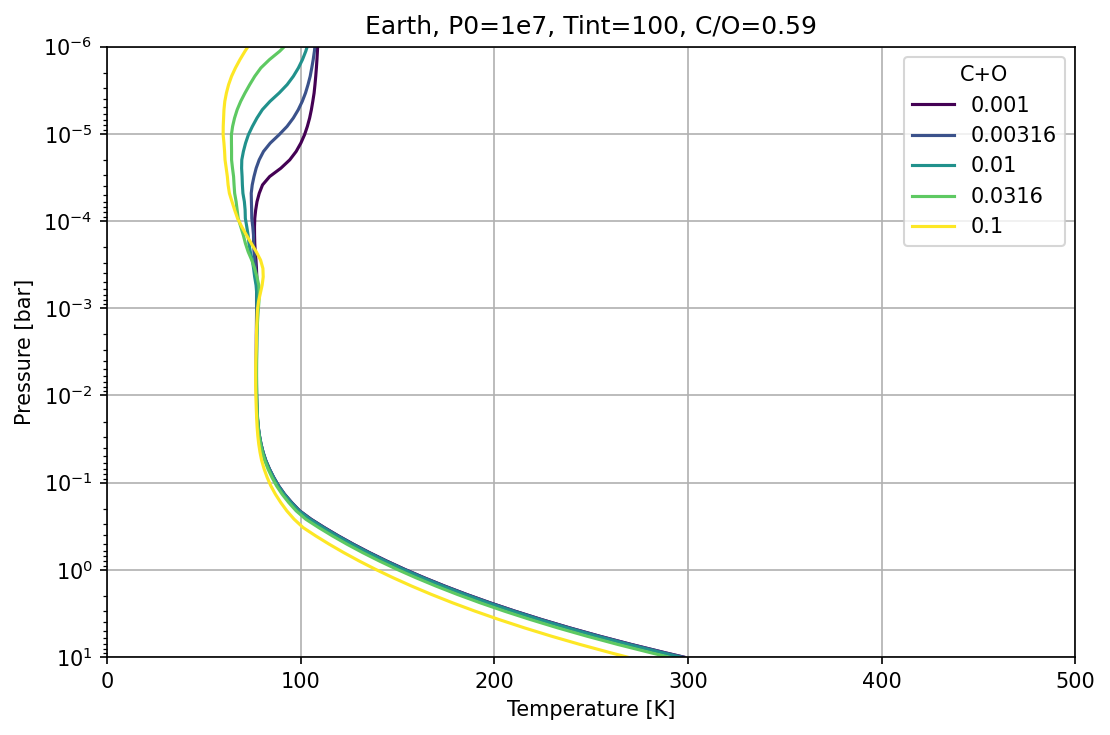

In [35]:
# test
fig, ax1 = plot_TP(loop_overs, data_dict["PTs"], data_dict["inds"], name, show_diff=False)
plt.show()

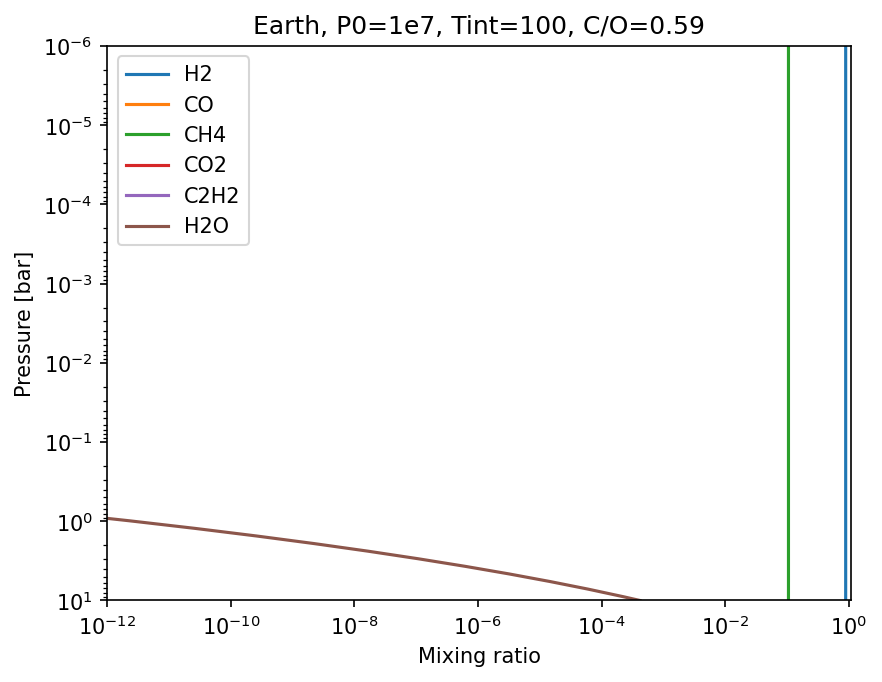

In [36]:
# plot mixing ratios for certain step
i = len(data_dict["mols"])-1
plot_mass_mr = False

threshold = None

if threshold is not None:
    mask = data_dict["mols"][i] > threshold
    mask = np.any(mask, axis=0)
else:
    target_molecules = ['H2', 'H2O', 'CO2', 'CO', 'CH4', 'C2H2']
    mask = np.isin(mol_names, target_molecules)
    #sort = np.argsort(data_dict["mols"][i][:,mask].max(axis=0))[::-1]

if plot_mass_mr:
    try:
        masses = [species_lib[name].weight for name in mol_names[mask]]
    except:
        raise KeyError("Error calculating mass: molecule name not found.")

    plt.plot(data_dict["mols"][i][:,mask]*masses/data_dict["mus"][i][:,None], data_dict["PTs"][i][:,0], label=mol_names[mask])
else:
    plt.plot(data_dict["mols"][i][:,mask], data_dict["PTs"][i][:,0], label=mol_names[mask])

xlog = True
if xlog:
    plt.xscale('log')
    plt.xlim(1e-12, 1.1e0)
else:
    plt.xlim(0, 1.05)

plt.yscale('log')
plt.ylim(data_dict["PTs"][0][0,0], data_dict["PTs"][0][-1,0]*1e1)

if plot_mass_mr:
    plt.xlabel('Mass mixing ratio')
else:
    plt.xlabel('Mixing ratio')
plt.ylabel('Pressure [bar]')
#plt.title(f'Mass mixing ratios for step {i}')
plt.title(name)

plt.legend()

(5, 3)


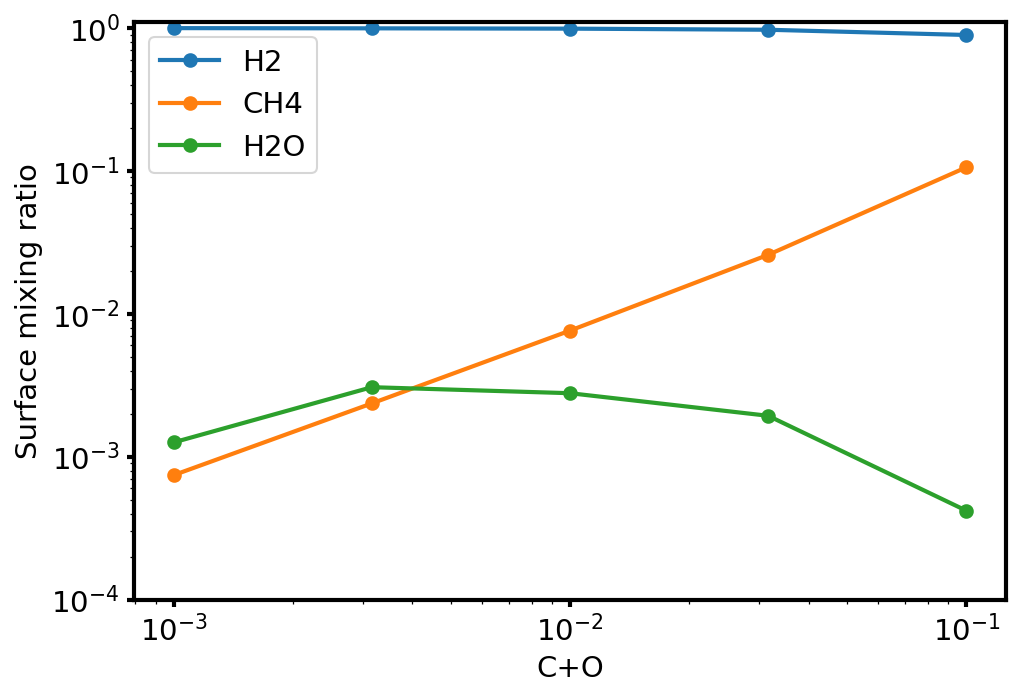

In [37]:
# plot mean mixing ratios dep. on loop_over variable

threshold = 1e-12

if threshold is not None:
    mask = np.zeros(data_dict["mols"][0].shape[1], dtype=bool)
    for i in range(len(data_dict["mols"])):
        new_mask = data_dict["mols"][i] > threshold
        new_mask = np.any(new_mask, axis=0)
        mask = np.logical_or(mask, new_mask)
else:
    target_molecules = ['H2', 'H2O', 'CO2', 'CO', 'CH4', 'C2H2']
    mask = np.isin(mol_names, target_molecules)
    #sort = np.argsort(data_dict["mols"][i][:,mask].max(axis=0))[::-1]

plot_mols = []

for i in range(len(data_dict["mols"])):
    # maybe log mean?
    #plot_mols.append(np.max(data_dict["mols"][i][:,mask], axis=0)) # mean / max / min
    plot_mols.append(data_dict["mols"][i][0,mask]) # surface layer

plot_mols = np.array(plot_mols)
print(plot_mols.shape)

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

for i in range(plot_mols.shape[1]):
    ax.plot(loop_overs, plot_mols[:,i], '.-', label=mol_names[mask][i], ms=10, mew=2)

log_x = np.abs(np.log10(loop_overs[-1])-np.log10(loop_overs[0])) > 1.5
if log_x:
    ax.set_xscale('log')
#ax.set_xticks(loop_overs)

ax.set_yscale('log')
ax.set_ylim(10**-4, 1.1e0)

ax.set_xlabel(loop_name.replace('plus', '+').replace('to', '/'))
ax.set_ylabel('Surface mixing ratio')
ax.legend(loc='lower right')

ax.set_title(name)

if True:
    ax.set_title('')
    #set_white(ax)
    increase_size(ax, linewidth=2, fontsize=14)
    # for P=1e7, remove x-axis label and ticks
    #ax.set_xlabel('')
    #ax.set_xticks([], minor=True)
    #ax.set_xticks([])

    plt.savefig('images/Paper1/MRs_' + name.replace(', ', '_').replace('/', 'to') + '.svg', format='svg', transparent=True)
